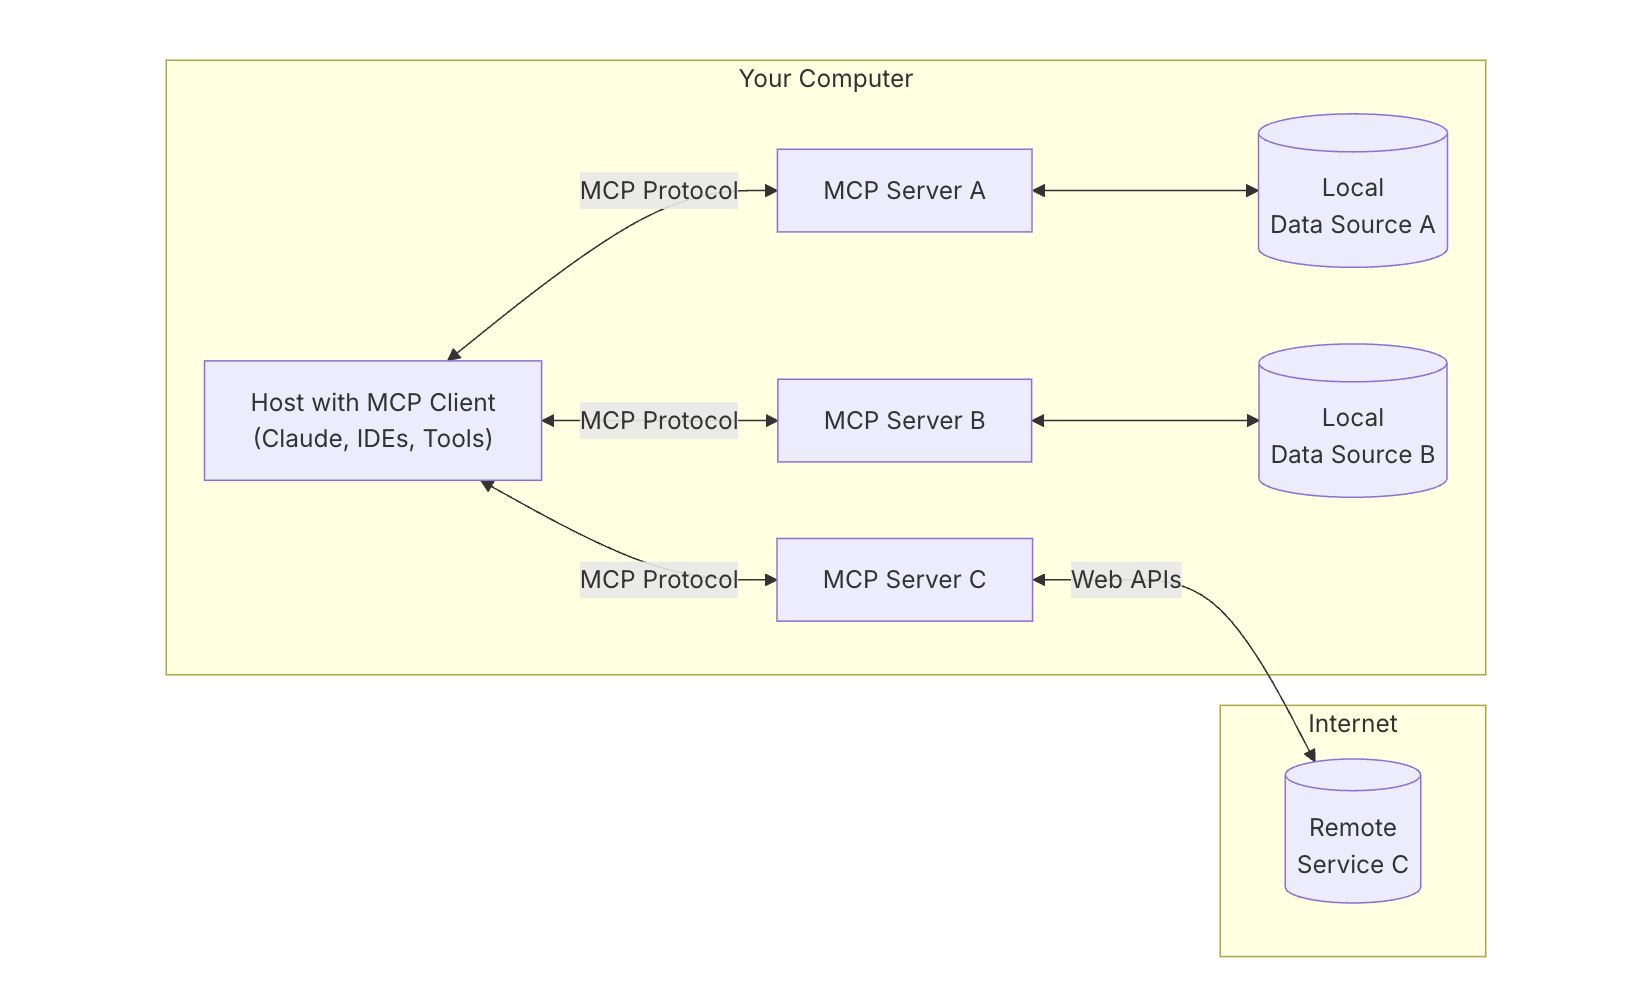

Anthropic's Model Context Protocol (MCP) is an open, standardized framework designed to connect AI models, particularly large language models (LLMs), seamlessly to various external data sources and tools. By providing standardized communication and integration methods, MCP simplifies the interaction between AI systems and their surrounding environments, reducing integration complexity and fragmentation

- MCP Hosts: Programs like Claude Desktop, IDEs, or AI tools that want to access data through MCP
- MCP Clients: Protocol clients that maintain 1:1 connections with servers
- MCP Servers: Lightweight programs that each expose specific capabilities through the standardized Model Context Protocol
- Local Data Sources: Your computer’s files, databases, and services that MCP servers can securely access
- Remote Services: External systems available over the internet (e.g., through APIs) that MCP servers can connect to

### Use the OPENAI SDK agents to connect to MCP

In [1]:
#%pip install openai openai-agents

In [ ]:
import asyncio
import os
import shutil

from agents import Agent, OpenAIChatCompletionsModel, Runner, set_tracing_enabled
from agents.mcp import MCPServer, MCPServerStdio
from dotenv import load_dotenv
from openai import AsyncAzureOpenAI

In [3]:
def get_azure_open_ai_client():
    """
    Creates and returns Azure OpenAI client instance.
    
    Returns:
        AsyncAzureOpenAI: Configured Azure OpenAI client
    """
    load_dotenv()
    
    return AsyncAzureOpenAI(
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    )


In [6]:
async def run(mcp_server: MCPServer):

    azure_open_ai_client = get_azure_open_ai_client()
    set_tracing_disabled(disabled=True)

    agent = Agent(
        name="Assistant",
        instructions="Use the tools to read the filesystem and answer questions based on those files.",
        model=OpenAIChatCompletionsModel(model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"), 
                                         openai_client=azure_open_ai_client),
        mcp_servers=[mcp_server],
    )

    # List the files it can read
    message = "Read the files in `sample_files` folder, and list them."
    print(f"Running: {message}")
    result = await Runner.run(starting_agent=agent, input=message)
    print(result.final_output)

    # Ask about books
    message = "Look at my favorite books. What is my #1 favorite book?"
    print(f"\n\nRunning: {message}")
    result = await Runner.run(starting_agent=agent, input=message)
    print(result.final_output)

    # Ask a question that reads then reasons.
    message = "Look at my favorite songs. Suggest one new song that I might like."
    print(f"\n\nRunning: {message}")
    result = await Runner.run(starting_agent=agent, input=message)
    print(result.final_output)


In [7]:
async def main():
    samples_dir =  "./sample_files"

    async with MCPServerStdio(
        name="Filesystem Server, via npx",
        params={
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-filesystem", samples_dir],
        },
    ) as server:
        await run(server)


if __name__ == "__main__":
    # Let's make sure the user has npx installed
    if not shutil.which("npx"):
        raise RuntimeError("npx is not installed. Please install it with `npm install -g npx`.")

    await main()


Running: Read the files in `sample_files` folder, and list them.
The files in the `sample_files` folder are:
1. favorite_books.txt
2. favorite_cities.txt
3. favorite_songs.txt


Running: Look at my favorite books. What is my #1 favorite book?
Your #1 favorite book is "To Kill a Mockingbird" by Harper Lee.


Running: Look at my favorite songs. Suggest one new song that I might like.
You have a diverse taste in music that includes classic rock, pop, soul, and contemporary hits. Given your playlist, which ranges from The Beatles and Queen to Taylor Swift and The Weeknd, I suggest you might like the song "Take On Me" by a-ha. It's a classic 80s pop-rock song with an iconic melody and energetic vibe that could blend well with your favorites like "Africa" by Toto and "Don't Stop Believin'" by Journey. Would you like me to suggest more songs?
